In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pims
import fsvpy as fsv

# Load images
First, we will use pims to import an image sequence.  If your image is saved as a tiff stack, you can just modify the example below.  However, PIMS can open a wide variety of image types, including many propriatary microscope formats.  For help using PIMS, see http://soft-matter.github.io/pims/v0.5/

We will load the example images included with the tutorial.  Change the below code to match the filepath to where you have saved these images.

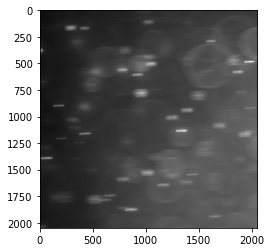

In [19]:
im = pims.open('/Users/mdriscoll/Northwestern/Lab/projects/ViSER/code/example_streaks.tif')
image = im[0]
plt.imshow(image, cmap = 'Greys_r')

Note that pims can be used to open a stack of images quite easily.  For example, if we wanted to open a stack in the above code we could instead write:

im = pims.open('/path_to_my_images/*.tif)

and the im object would now be a stack of all of the .tif images in that directory.  You can then access individual images by referencing in the same way as a list, e.g. im[4].  Note that the images are not all loaded at once, but instead called as needed, so this is not a memory-heavy object.  Opening images as stacks in this way is great for processing may images in a loop.  For more inofrmation, see the pims documentation.


# Locate streaks
Now, we can locate streaks in the image.  This accomplished using the function locate_streaks. This function identifies streaks in your image using a contour finding algorithm and then returns a list where each entry contains the coordinates of a streak.  locate_streaks first pre-processes the image with a bandpass filter and a gaussian blur (the streak properties are measured on the raw data).  It has a default value of 5 times the standard deviation in intensity as a contour intensity level, but this can be adjusted using the optional contour_value argument, see the API for details.  

In [20]:
s = fsv.locate_streaks(image)   

To see the streaks we have found, we can use the function plot_streaks

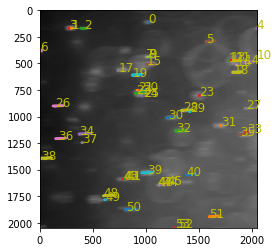

In [21]:
fsv.plot_streaks(s, image)

#Filter streaks 
As we can see in the above image, many of the streaks we find are out of focus or too close to the edge.  To filter these out, we need to first measure their properties using the parameters function.  This function takes as an input the list of streaks you found and returns a dataframe with streak properties.  For more on pandas dataframes, start here: https://pandas.pydata.org/docs/user_guide/10min.html

In [22]:
streak_properties = fsv.parameters(s)

In [23]:
print(streak_properties)

    streak_id            x            y         area   perimeter     corner_x  \
0         0.0  1022.376592   113.287224     7.214097   10.925839  1020.166943   
1         1.0   300.096762   166.202277   101.541040   57.041749   289.329326   
2         2.0   415.591794   168.287572   268.759480  133.319767   382.036570   
3         3.0   272.810776   168.178447    13.394471   13.954616   269.992506   
4         4.0  2041.468647   170.764097     1.614809    5.100334  2040.411393   
5         5.0  1605.727425   291.859680   801.976619  194.320057  1560.319193   
6         7.0  1002.635993   436.975070    21.901189   23.606848   996.609845   
7         8.0  1019.366769   437.199178    35.740521   29.941133  1012.227119   
8         9.0  1033.152608   436.881273    24.068391   21.447587  1028.137376   
9        10.0  2042.930446   450.369948    31.200625   20.568353  2039.132308   
10       11.0  1835.885989   470.498890   208.680520  115.883249  1809.693982   
11       12.0  1786.023541  

We now have a pandas dataframe which lists the properties of all of our identified streaks, which we can then use to filter out undesired streak identifications.  There are optional arguments to allow for changing the default image size of (2048, 2048) turning off edge filtering, and to adjust the filtering parameters. 

The default is to filter all streaks that are less than 7 pixels in height, whose aspect ratio is less than 2, and those within 100 pixels of the edge of our image, as they are likely to be incomplete.

In [24]:
filtered_streaks = fsv.filter(streak_properties)

In [25]:
print(filtered_streaks)

    streak_id            x            y         area   perimeter     corner_x  \
1         1.0   300.096762   166.202277   101.541040   57.041749   289.329326   
5         5.0  1605.727425   291.859680   801.976619  194.320057  1560.319193   
14       15.0  1042.577656   505.007556   574.746496  181.216562   998.995046   
16       17.0   774.708475   562.364387   736.928580  182.226837   730.950598   
17       18.0  1859.168463   580.243280   769.439514  195.155049  1812.849117   
18       19.0   915.428069   605.996943   950.961470  201.439617   868.695449   
21       22.0   949.434106   778.625488   670.129329  204.971684   898.779479   
25       26.0   175.147409   898.497118   867.795790  217.240639   122.299701   
27       28.0  1382.299680   939.793544   603.871767  207.726148  1331.183510   
29       30.0  1240.453132  1009.170744   520.130466  203.373696  1189.645888   
31       32.0  1328.992529  1133.802945  1325.717537  228.421480  1275.428322   
33       34.0   421.633044  

 We can see which streaks survived by using the plot_filtered_streaks function.  It takes as arguments your image, the filtered streak properties dataframe, and the list of found streaks.  

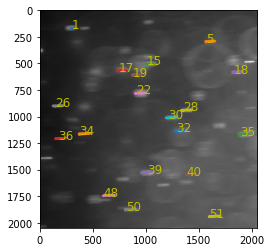

In [26]:
fsv.plot_filtered_streaks(s, filtered_streaks, image)

As you can see above, the filtering elminated some of the streaks, as well as those too close to the edge.  Depending on your images, more or less filtering may be required.  We will do another filtering step once we have fit our streak profiles, which will help to remove out-of-focus streaks.  It is often best to only lightly filter at the identification stage, and then add filters which remove statistical outliers at a later stage, once you have a whole population of streaks.

# Refine streak properties: fit streaks
Now that we are happy with our identification and filtering, we are ready to more precisely extract our streak properties.  To do so, we will use the fit_shape function.  This function uses the location of the streak to extract a piece of the original image, and then uses fitting function to extract streak characteristics.  These function assume straight streaks, though they may be an angle relative to the axis (the fitting functions rotate the streak before doing the fit).  If you have curved streaks, see the example below illustrated the optional package - it is much slower, but can accomadate streaks of arbitrary shape.  If the fitting does not converge, streak height and width are set to zero.  The averaging and other parameters for fitting can be set with optional arguments, see the API for details.

In [27]:
fitted_streaks = fsv.fit_shape(image, filtered_streaks)

/Users/mdriscoll/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


To see the results of the fit, we can use the plot_fit function.  The two lines plotted on each streak represent the height and width returned by the fitting algorithm.

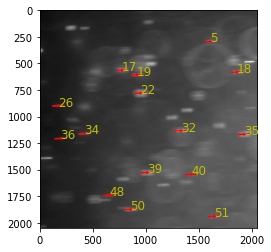

In [28]:
fsv.plot_fit(image, fitted_streaks)

All of the streak data is in the dataframe 'fitted_streaks'.  To save it for future processing, or working with it in another environment, the easiest thing to do is save the data frame as a comma-seperated-value file; make sure you indicate the filepath where you want this to save.

In [29]:
fitted_streaks.to_csv('fitted_streaks.csv')

# Curvy streaks
What we have done thus far represents the basic functionality of FSVpy for streaks in uniaxial flow, e.g. streaks that look like rectangles.  If your flow field is more complex, your data will not look like this.  For example, an example image from particles flowing around a post is included in the tutorial.

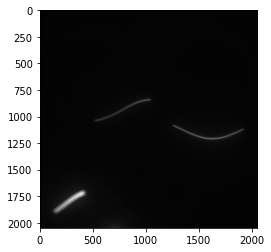

In [30]:
im2 = pims.open('/Users/mdriscoll/Northwestern/Lab/projects/ViSER/code/example_curvy_streaks.tif')
c_image = im2[0]
plt.imshow(c_image, cmap = 'Greys_r')

The first step of processing remains the same - locate the streaks.

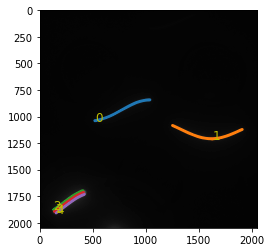

In [31]:
c = fsv.locate_streaks(c_image)
fsv.plot_streaks(c, c_image)

We can see that there are bad streaks identified, but here the filtering is less straightforward, as the bounding box is not a good representation of the streak size.  We can still filter using the filter_diag_size function, which removes streaks which have a diagonal size less than a certain value.  For example, here we filter out streaks which have a diagonal size less than 400.

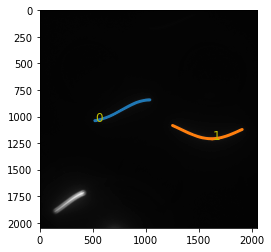

In [32]:
filtered_c = fsv.filter_diag_size(c, min_diag_size = 400)
fsv.plot_streaks(filtered_c, c_image)

Note that point ordering is not guantaneed, the contour algorithm return points ordered along of the axes; this is why we have to use a different (and more computationally expensive) routine for non-rectangular streaks.  Locating is the same, but a new sorting step is necessary (this is why this is slower than the fitting method).  This happens behind-the-scenes when runing the centerline method.  Here, you input the list of contours and a list of medial axes (contour centerlines) are returned.  

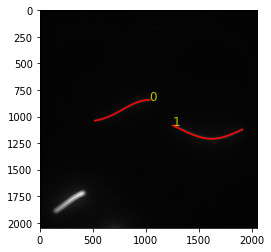

In [34]:
center = fsv.centerlines(filtered_c, c_image)
fsv.plot_centerlines(center, c_image)


The above covers the basics of extrating streaks from an image.  You can now use the streak properties to characterize the flow velocity, as well as additionally use the intensity information along the streak (best returned by centerlines) to characterize accelerations.